In [23]:
# Import the library
import os
import rasterio
from rasterio import plot
from rasterio.plot import show  # display images
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # Mathematical python module
from osgeo import gdal 
import fiona
import pandas as pd
import geopandas as gpd
import utm

import xarray  # Data storage/format 
from IPython.display import Markdown  # Nicer display
import folium  # Display
#from eodag import EODataAccessGateway  # Query data catalog
from ipyleaflet import Map, basemaps, LayersControl  # Display
#from qgislab import qgislab  # Display

In [24]:
# Define the directory for the work
os.chdir("/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/WH_Model")
datapath = "/Users/metogbedjihouessi/Documents/EO-Africa/"

In [25]:
###*************************
# Convert ground observation csv data into shapefile
###*************************

EPSG:32631


<Axes: >

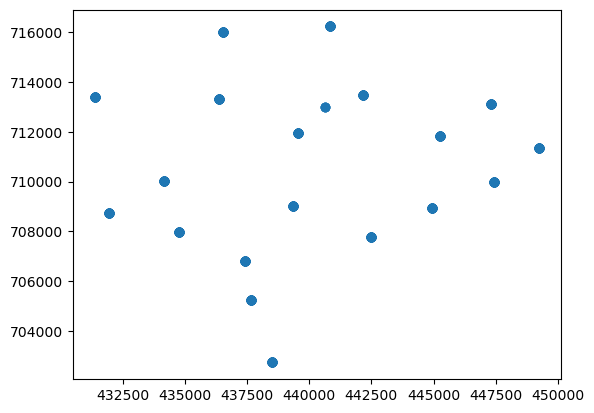

In [26]:
# Import points from field data (chla and Turb) csv file
pointDf = pd.read_csv(datapath+'/Livrables/Nokoue_2019_2022_Chla_Tub_Sal.csv', header=0)

# Convert lat lon to utm (all the observation in the study)
pointDf['utm'] = pointDf[["Lat", "Lon"]].apply(lambda row: utm.from_latlon(*row), axis=1)
utm_cols = ['easting', 'northing', 'zone_number', 'zone_letter']
for n, col in enumerate(utm_cols):
    pointDf[col] = pointDf['utm'].apply(lambda location: location[n])
pointDf = pointDf.drop('utm', axis=1)
pointDf.head()

# Define schema of the shapefile
schema = {
    'geometry':'Point',
    'properties':[('Date','str'), ('Station','str'), ('Sal','float'), ('Turb', 'float'), ('Chla', 'float')]
}

# Open a fiona object
ChlaNkeShp = fiona.open(datapath+'/Algorithm/WH_Model/Chla_NkePoints.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:32631")

# Iterate over each row in the dataframe and save record
for index, row in pointDf.iterrows():
    rowDict = {
        'geometry': {'type': 'Point',
                     'coordinates': (row.easting,row.northing)},
        'properties': {'Date': row.Date,
                       'Station': row.Station,
                       'Sal': row.Salinity,
                       'Turb': row.Turbidity_FTU,
                       'Chla': row.Chl_a}
    }
    ChlaNkeShp.write(rowDict)
#close fiona object
ChlaNkeShp.close()

# Open the shapefile 
ChlaNkePoints = gpd.read_file(datapath+'/Algorithm/WH_Model/Chla_NkePoints.shp')
print(ChlaNkePoints.crs)
ChlaNkePoints.plot()

EPSG:32631


<Axes: >

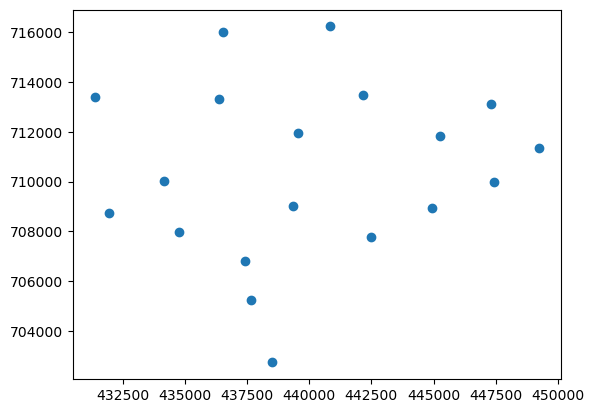

In [27]:
# Shapefile that will be used to extract chla value form raster

ObsPointNk = pd.read_csv(datapath+'/Livrables/Coordonnees_Etudes_Nokoue.csv', header=0)
ObsPointNk['utm'] = ObsPointNk[["Lat", "Lon"]].apply(lambda row: utm.from_latlon(*row), axis=1)
utm_cols = ['easting', 'northing', 'zone_number', 'zone_letter']
for n, col in enumerate(utm_cols):
    ObsPointNk[col] = ObsPointNk['utm'].apply(lambda location: location[n])
ObsPointNk = ObsPointNk.drop('utm', axis=1)

schema = {
    'geometry':'Point',
    'properties':[('Station','str')]
}

ObsPointNkShp = fiona.open(datapath+'/Algorithm/WH_Model/GroundObsPoints.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:32631")

for index, row in ObsPointNk.iterrows():
    rowDict = {
        'geometry': {'type': 'Point',
                     'coordinates': (row.easting,row.northing)},
        'properties': {'Station': row.Station}
    }
    ObsPointNkShp.write(rowDict)

# Close fiona object
ObsPointNkShp.close()

# Open the shapefile 
ObsPointNke = gpd.read_file(datapath+'/Algorithm/WH_Model/GroundObsPoints.shp')
print(ObsPointNke.crs)
ObsPointNke.plot()

In [28]:
###*************************
# Chla model calibrtion: Exemple for Image of 20200106
###*************************

In [29]:
# Cropping the images to lake nokoue shape
inputPath = "/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/"
outputPath = "/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/"

# To select the tif files
bandlist = [band for band in os.listdir(inputPath) if band[-5:]=='m.jp2']

#To define the location of the shapefile to be used for clipping
shp_clip = "/Users/metogbedjihouessi/Documents/Djihouessi/My Documents/IHE-2016/Msc_Research/Images_Classification/2016_12/2016_12_12/Nokoue_Shp/Nokoué.shp"

#To clip multiple raster
for band in bandlist:
    print(outputPath + band[:-4] + '_clip_Nke' + band[-4:])
    options = gdal.WarpOptions(cutlineDSName = shp_clip, cropToCutline = True)
    outBand = gdal.Warp(srcDSOrSrcDSTab = inputPath+band,
                        destNameOrDestDS = outputPath+band[:-4]+'_clip_Nke'+band[-4:],
                        options = options)
    outBand = None

/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/T31NDH_20200106T100401_B03_20m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/T31NDH_20200106T100401_B12_20m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/T31NDH_20200106T100401_B02_20m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/T31NDH_20200106T100401_SCL_20m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/T31NDH_20200106T100401_B11_20m_clip_Nke.jp2
/Users/metogbedjihouessi/Documents/EO-Africa/Algorithm/Sentinel_Images/202001/L2A_T31NDH_A023714_20200106T101428/IMG_DATA/R20m/T31NDH_20200106T10

In [30]:
# Import and rename the images bands
imagePath = inputPath
B03 = rasterio.open(imagePath+'T31NDH_20200106T100401_B03_20m_clip_Nke.jp2', driver='JP2OpenJPEG')
B04 = rasterio.open(imagePath+'T31NDH_20200106T100401_B04_20m_clip_Nke.jp2', driver='JP2OpenJPEG')
B05 = rasterio.open(imagePath+'T31NDH_20200106T100401_B05_20m_clip_Nke.jp2', driver='JP2OpenJPEG')
B06 = rasterio.open(imagePath+'T31NDH_20200106T100401_B06_20m_clip_Nke.jp2', driver='JP2OpenJPEG')
B07 = rasterio.open(imagePath+'T31NDH_20200106T100401_B07_20m_clip_Nke.jp2', driver='JP2OpenJPEG')
B8A = rasterio.open(imagePath+'T31NDH_20200106T100401_B8A_20m_clip_Nke.jp2', driver='JP2OpenJPEG')

#Converting to float
R560 = B03.read(1).astype('float32')
R665 = B04.read(1).astype('float32')
R705 = B05.read(1).astype('float32')
R740 = B06.read(1).astype('float32')
R783 = B07.read(1).astype('float32')
R865 = B8A.read(1).astype('float32')

In [31]:
#******
# Normalized difference chlorophyll index (NDCI) according to Mishra and Mishra, 2012
NDCI = np.divide((R705 - R665), (R705 + R665), 
                          out=np.zeros_like(R705 + R665), where=(R705 + R665) != 0)

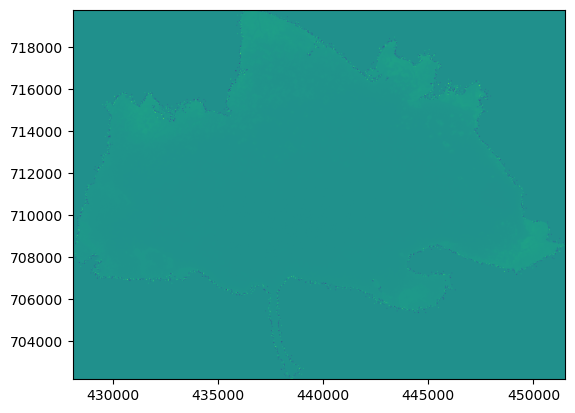

In [32]:
# Transforming the NDCI matrix to a Raster Image (RI)
NDCI_RI = rasterio.open(datapath+'/Algorithm/WH_Model/NDCI.tiff', 'w', driver='Gtiff',
                          width = B03.width,
                          height = B03.height,
                          count = 1,
                          crs = B03.crs,
                          transform = B03.transform,
                          dtype='float64'
                         )
NDCI_RI.write(NDCI, 1)
NDCI_RI.close()

# Plotting the NDVI Image
NDCI_RI = rasterio.open(datapath+'/Algorithm/WH_Model/NDCI.tiff')
plot.show(NDCI_RI)

# Extracting the NDCI value at the ground observation points

values = pd.Series()

# Read input shapefile with fiona and iterate over each feature
with fiona.open(datapath+'/Algorithm/WH_Model/GroundObsPoints.shp') as shp:
    for feature in shp:
        station_name = feature['properties']['Station']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rasterio.open(datapath+'/Algorithm/WH_Model/NDCI.tiff') as src:
            value = [v for v in src.sample([coords])][0][0]
        # Update the pandas serie accordingly
        values.loc[station_name] = value

# Write records into a CSV file
values.to_csv('NDCI.csv')
data_NDCI = pd.read_csv('NDCI.csv')
data_NDCI.columns.values[0] = "Station"
data_NDCI.columns.values[1] = "NDCI"
data_NDCI.to_csv('NDCI.csv')

In [33]:
#******
# Chlorophyll a indice according to the reference Cairo et al., 2020
CI_Cairo = np.divide(R740, R560, 
                          out=np.zeros_like(R560), where=(R560) != 0)

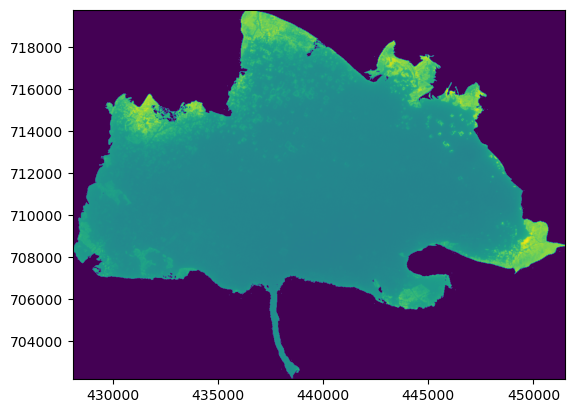

In [34]:
# Transforming the CI_cairo matrix to raster image
CI_Cairo_RI = rasterio.open(datapath+'/Algorithm/WH_Model/CI_Cairo.tiff', 'w', driver='Gtiff',
                          width = B03.width,
                          height = B03.height,
                          count = 1,
                          crs = B03.crs,
                          transform = B03.transform,
                          dtype='float64'
                         )
CI_Cairo_RI.write(CI_Cairo, 1)
CI_Cairo_RI.close()

# Plotting the NDVI Image
CI_Cairo_RI = rasterio.open(datapath+'/Algorithm/WH_Model/CI_Cairo.tiff')
plot.show(CI_Cairo_RI)

# Extracting the NDCI value at the ground observation points

values = pd.Series()

# Read input shapefile with fiona and iterate over each feature
with fiona.open(datapath+'/Algorithm/WH_Model/GroundObsPoints.shp') as shp:
    for feature in shp:
        station_name = feature['properties']['Station']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rasterio.open(datapath+'/Algorithm/WH_Model/CI_Cairo.tiff') as src:
            value = [v for v in src.sample([coords])][0][0]
        # Update the pandas serie accordingly
        values.loc[station_name] = value

# Write records into a CSV file
values.to_csv('CI_Cairo.csv')
data_CI_cairo = pd.read_csv('CI_Cairo.csv')
data_CI_cairo.columns.values[0] = "Station"
data_CI_cairo.columns.values[1] = "CI_Cairo"
data_CI_cairo.to_csv('CI_Cairo.csv')